In [1]:
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../src')  # to avoid importing utils Anaconda package
from plot_utils import plot_maze_stats
from parameters import RewNames, INVALID_STATE
from TDLambda_Home2Rwd_model import TDLambda_Home2Rwd
os.chdir('../TDLambda_Home2Rwd_stan')

model = TDLambda_Home2Rwd()

In [2]:
def reformat_realtraj(real_traj):
    '''
    Remove INVALID_STATE from real trajectories and reshape 3D array to a 1D array for plotting functions
    :param real_traj: 3D array: [N, BOUTS, TRAJ_LENGTH] of extracted trajectories
    :return real trajectories formatted as a list of lists without INVALID_STATE
    '''
    real_traj_lists = [[] for _ in range(len(real_traj))]
    for mouseID in np.arange(len(real_traj)):
        for traj in real_traj[mouseID]:
            valid_traj = traj[traj!=INVALID_STATE]
            if len(valid_traj):
                real_traj_lists[mouseID].extend(valid_traj)
    return real_traj_lists

def revise_subfits(real_traj, exclude=None):
    '''
    Exclude specific mice from analysis
    :param real_traj: 3D array: [N, BOUTS, TRAJ_LENGTH] of extracted trajectories
    :param exclude: list of mouseIDs to exclude from simulations if their parameter fits didn't converge in STAN
    :return parameter fits, bout counts, rewards and miceIDs, ONLY of mice to be included in the analysis
    '''
    if exclude:
        for mouseID in exclude:
            org_sub_fits.pop(mouseID)
        sub_fits = dict(zip(np.arange(10-len(exclude)), org_sub_fits.values()))
    else:
        sub_fits = org_sub_fits
    real_mouseID = set(np.arange(10)) - set(exclude)
    
    # Retrieve number of bouts each mouse learned over
    N_BOUTS_TO_GENERATE = [len(np.where(traj_list[:,0]!=INVALID_STATE)[0]) for traj_list in real_traj]
    N_BOUTS_TO_GENERATE = [N_BOUTS_TO_GENERATE[id] for id in real_mouseID]
    
    # Sum total rewards each mouse earned
    NRWDS = np.zeros(len(real_traj), dtype=int)
    for mouseID in np.arange(len(real_traj)):
        for traj_list in real_traj[mouseID]:
            NRWDS[mouseID] += len(np.where(traj_list==116)[0])
    NRWDS = [NRWDS[id] for id in real_mouseID]    
    
    return sub_fits, real_mouseID, N_BOUTS_TO_GENERATE, NRWDS

def rand_LL(real_traj_lists):
    '''
    Calculate the log likelihood of a random policy fitting to real data of each mouse
    :param real_traj_lists[len(real_traj)] list containing a list of combined real trajectories for each mouse
    :return 1-by-len(real_traj) array of random log likelihoods
    '''
    indv_rand_LL = np.zeros(len(real_traj))
    for mouseID in np.arange(len(real_traj)):
        indv_rand_LL[mouseID] += len(real_traj_lists[mouseID]) * np.log(0.33)
    return indv_rand_LL

# Loading real data
real_traj = pickle.load(open('traj_data/real_traj/rewMICE_post_firstR_every_Rvisit.pkl','rb'))
real_traj_lists = reformat_realtraj(real_traj)
indv_rand_LL = rand_LL(real_traj_lists)

# Retrieving fitted subject parameters
org_sub_fits = pickle.load(open('results/TDlamda_Rvisit_real_init0.1/sub_fits.pkl','rb'))
sub_fits, real_mouseID, N_BOUTS_TO_GENERATE, NRWDS = revise_subfits(real_traj, [0,2,8])

In [3]:
avg_state_value_hist, _ = model.simulate_avg(sub_fits, RUNS=20, N_BOUTS_TO_GENERATE=N_BOUTS_TO_GENERATE)

Running simulation  0
Running simulation  1
Running simulation  2
Running simulation  3
Running simulation  4
Running simulation  5
Running simulation  6
Running simulation  7
Running simulation  8
Running simulation  9
Running simulation  10
Running simulation  11
Running simulation  12
Running simulation  13
Running simulation  14
Running simulation  15
Running simulation  16
Running simulation  17
Running simulation  18
Running simulation  19


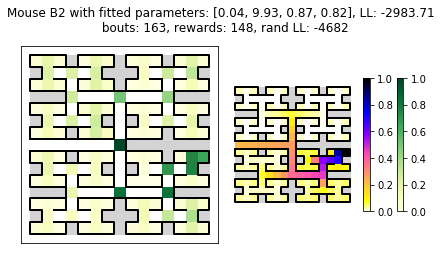

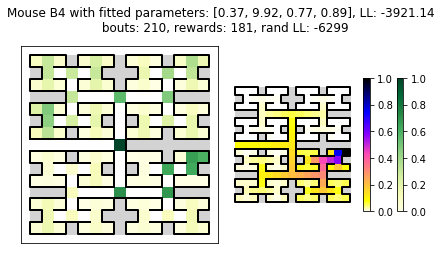

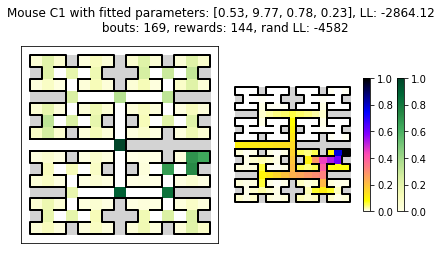

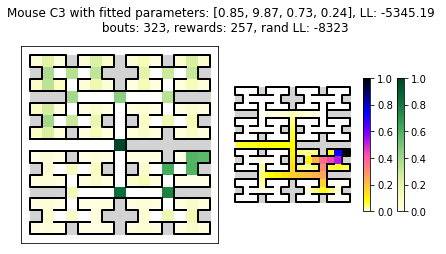

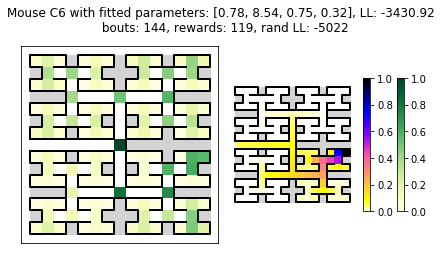

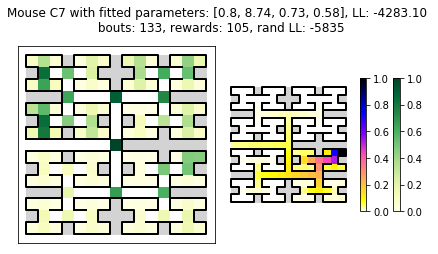

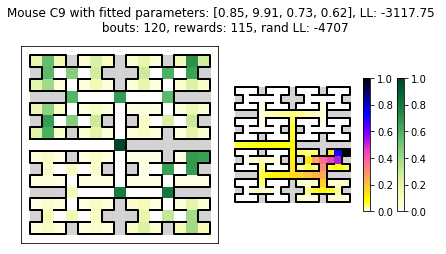

In [4]:
# Plotting frequency of real trajectories and average state values of predicted trajectories
for simID, realID in enumerate(real_mouseID):    
    # Arrange plots for a side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1,2)
    plot_maze_stats(real_traj_lists[realID], 'states', 'YlGn', axes=ax1, display=False)
    plot_maze_stats(avg_state_value_hist[simID], 'state_values', 'gnuplot2_r', axes=ax2, display=False)
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    fig.suptitle('Mouse %s with fitted parameters: %s, LL: %.2f \n bouts: %i, rewards: %i, rand LL: %.f' 
                 %(RewNames[realID], str([np.round(val,2) for val in sub_fits[simID][:-1]]), sub_fits[simID][-1], 
                   N_BOUTS_TO_GENERATE[simID], NRWDS[simID], indv_rand_LL[realID]))